In [1]:
# We'll need PyTorch, torchvision for dataset utilities, and matplotlib for visualization.

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
# Load the CIFAR-10 dataset.
# It contains 60,000 32x32 color images in 10 classes, with 6,000 images per class.

transform = transforms.Compose([ transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #Convert image to PyTorch tensor. Normalize image to [-1, 1]


# Download and load the training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

# Download and load the testing dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)


100%|██████████| 170M/170M [00:02<00:00, 62.3MB/s]


In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # First convolutional layer: 3 input channels (RGB), 6 output channels, 5x5 kernel
        self.conv1 = nn.Conv2d(3, 6, 5)

        # Max pooling layer with 2x2 kernel
        self.pool = nn.MaxPool2d(2, 2)

        # Second convolutional layer: 6 input channels, 16 output channels, 5x5 kernel
        self.conv2 = nn.Conv2d(6, 16, 5)

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # Flattened image to 120 features
        self.fc2 = nn.Linear(120, 84)          # From 120 to 84
        self.fc3 = nn.Linear(84, 10)           # Output layer: 10 classes for CIFAR-10

    def forward(self, x):
        # Pass through first conv, apply ReLU, then pool
        x = self.pool(F.relu(self.conv1(x)))

        # Pass through second conv, apply ReLU, then pool
        x = self.pool(F.relu(self.conv2(x)))

        # Flatten for fully connected layers
        x = x.view(-1, 16 * 5 * 5)

        # Pass through fully connected layers with ReLU
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Final layer without activation (CrossEntropyLoss applies softmax internally)
        x = self.fc3(x)

        return x

# Initialize the network
net = Net()


In [4]:
# Loss function and optimizer.
# Cross-Entropy Loss is suited for classification.
# SGD (Stochastic Gradient Descent) will help us update the weights.

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [5]:
# We'll loop over the dataset twice (2 epochs).
# In each epoch, we go through the training data in mini-batches and update weights.

for epoch in range(2):  # number of times to loop over the entire dataset
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):  # enumerate gives us batch index i

        inputs, labels = data  # Get inputs and their true labels

        optimizer.zero_grad()  # Zero the gradients

        outputs = net(inputs)          # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()               # Backpropagate
        optimizer.step()             # Optimize weights

        running_loss += loss.item()
        if i % 2000 == 1999:  # Every 2000 batches, print progress
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')


[1,  2000] loss: 2.281
[1,  4000] loss: 1.944
[1,  6000] loss: 1.712
[1,  8000] loss: 1.611
[1, 10000] loss: 1.558
[1, 12000] loss: 1.493
[2,  2000] loss: 1.430
[2,  4000] loss: 1.394
[2,  6000] loss: 1.370
[2,  8000] loss: 1.347
[2, 10000] loss: 1.321
[2, 12000] loss: 1.317
Finished Training


In [6]:
# This tells us how well the model performs on unseen data.

correct = 0
total = 0

# Disable gradient calculation for testing (saves memory & computation)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)                      # Get model predictions
        _, predicted = torch.max(outputs.data, 1)  # Take class with highest probability
        total += labels.size(0)                    # Total number of images
        correct += (predicted == labels).sum().item()  # Correct predictions

# Print final test accuracy
print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')


Accuracy of the network on the 10000 test images: 53.57 %


In [7]:
# We'll save just the model's parameters (state_dict), not the full architecture.
# PyTorch encourages saving the model structure in code and weights separately using state_dict.


PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

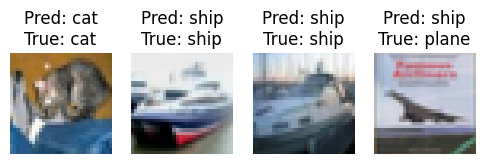

In [14]:
import numpy as np

# When we want to load the model again, we instantiate the class and load the parameters.
# This is useful for continuing training, evaluation, or deployment.


net = Net()
net.load_state_dict(torch.load(PATH))
net.eval()


# Load classes
classes = ['plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# Load test data
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

# Get a batch
dataiter = iter(testloader)
images, labels = next(dataiter)

# Predict
outputs = net(images)
_, predicted = torch.max(outputs, 1)

# Unnormalize images
images = images / 2 + 0.5
npimg = images.numpy()

# Plot images
fig, axes = plt.subplots(1, 4, figsize=(6, 2))
for i in range(4):
    ax = axes[i]
    img = np.transpose(npimg[i], (1, 2, 0))
    ax.imshow(img, interpolation='nearest')  # avoid blur
    ax.set_title(f"Pred: {classes[predicted[i]]}\nTrue: {classes[labels[i]]}")
    ax.axis('off')
